In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
tf.random.set_seed(1)
np.random.seed(1)
import warnings
warnings.filterwarnings("ignore")

In [112]:
df = pd.read_csv("/content/drive/MyDrive/colab/account_data.csv",parse_dates = True)

In [113]:
a = list(df['accountId'].unique())
df = df[df['accountId']=="5ffdb895b08512986422b08c"]
df=df.copy()
df.date = pd.to_datetime(df.date)
df.sort_values(by="date", inplace=True, ignore_index=True)
account_data = df

In [114]:
keyword_ids = account_data["keywordId"].unique()
keywordwise_sales = account_data.groupby("keywordId")["sales"].sum()
nonzero_sales_keywords = keywordwise_sales[keywordwise_sales>0]
nonzero_sales_keywords.sort_values(ascending=False, inplace=True)
keywords_req = list(nonzero_sales_keywords.index)
keyword_ids = keywords_req[:35]
account_data =  account_data[account_data['keywordId'].isin(keyword_ids)]

In [115]:
account_data.reset_index(inplace = True)
account_data.sort_values(by="date", inplace=True, ignore_index=True)
account_data.drop(columns = "index",inplace = True)
account_data.sort_values(by = 'date',inplace = True)
account_data.reset_index(inplace = True)
account_data.drop(columns = "index",inplace = True)
account_data['clicks'] = account_data["clicks"].astype("int64")
account_data['impressions'] = account_data["impressions"].astype("int64")
account_data['orders'] = account_data["orders"].astype("int64")
account_data["keywordId"] = account_data["keywordId"].astype(str)
account_data["cpc"] = account_data["spend"]/account_data["clicks"] 
account_data["cpc"].interpolate("linear", inplace=True)

In [116]:
account_data.set_index('date',inplace = True)

In [117]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [118]:
account_data = account_data[account_data['sales']>1000] 
account_data = account_data[account_data['sales']<45000]

In [119]:
account_data

,accountId,adGroupId,campaignId,keywordId,sales,spend,clicks,impressions,orders,cpc
date,,,,,,,,,,
2022-01-20,5ffdb895b08512986422b08c,254288108972047,274494157786797,54404635410436,4032.200000,139.490000,39,2162,4,3.576667
2022-01-20,5ffdb895b08512986422b08c,218427629916993,85580432953015,87296464240522,1270.340000,160.160000,21,200,1,7.626667
2022-01-20,5ffdb895b08512986422b08c,205031194777134,63953084720638,187760894834115,8822.540000,298.930000,120,3727,13,2.491083
2022-01-20,5ffdb895b08512986422b08c,155972832827060,85580432953015,2765709881042,32964.460000,3167.270000,361,5702,26,8.773601
2022-01-20,5ffdb895b08512986422b08c,155972832827060,85580432953015,67652894855323,9680.500000,1250.170000,91,2466,7,13.738132
...,...,...,...,...,...,...,...,...,...,...
2023-01-20,5ffdb895b08512986422b08c,16386791421931,43979301427275,13560133409311,23635.201901,2727.040428,238,14461,21,11.458153
2023-01-20,5ffdb895b08512986422b08c,150320593958435,43979301427275,148684437353570,14069.508804,1018.992408,143,42216,11,7.125821
2023-01-20,5ffdb895b08512986422b08c,196156035254768,42405100299601,210247423029007,6316.081499,197.860847,95,7991,7,2.082746


In [120]:
validate = account_data[['sales','spend', 'clicks', 'impressions', 'orders','keywordId']].tail(1000)
account_data.drop(account_data.tail(1000).index,inplace=True)

In [121]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(account_data[['sales','spend', 'clicks', 'impressions', 'orders']])
dataY = y_scaler.fit_transform(account_data[['sales']])

In [122]:
hist_window = 1000
horizon = 1000
TRAIN_SPLIT = 6000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [123]:
print ('Single window of past history')
print(x_train_multi[0])
print(len(x_train_multi[0]))
print('\n Target horizon')
print(y_train_multi[0])
print(len(y_train_multi[0]))

Single window of past history
[[6.91878487e-02 1.02688517e-02 8.74439462e-02 5.00051688e-03
  9.75609756e-02]
 [6.14379734e-03 1.18631850e-02 4.70852018e-02 2.83683169e-04
  2.43902439e-02]
 [1.78535332e-01 2.25668922e-02 2.69058296e-01 8.76292501e-03
  3.17073171e-01]
 ...
 [4.14711153e-02 1.65466195e-02 6.72645740e-02 2.30071858e-02
  4.87804878e-02]
 [3.62936324e-02 8.20663629e-03 1.30044843e-01 1.59920376e-02
  4.87804878e-02]
 [1.85561882e-01 9.27238627e-02 2.53363229e-01 2.85077544e-02
  4.87804878e-02]]
1000

 Target horizon
[[0.06183191]
 [0.26803021]
 [0.00758588]
 [0.09330983]
 [0.12113484]
 [0.14432533]
 [0.06855953]
 [0.30879865]
 [0.17701909]
 [0.05168581]
 [0.11908298]
 [0.67435996]
 [0.05300825]
 [0.28582407]
 [0.09089198]
 [0.26004202]
 [0.00872702]
 [0.0406256 ]
 [0.03006979]
 [0.40483709]
 [0.08665084]
 [0.15772181]
 [0.06432649]
 [0.36739728]
 [0.00351976]
 [0.12295086]
 [0.05878338]
 [0.00546183]
 [0.1370968 ]
 [0.14362461]
 [0.07013406]
 [0.17583415]
 [0.06264394]


In [124]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [125]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_multi.shape[-2:], return_sequences=True,activation = 'relu'),
    tf.keras.layers.LSTM(units=32,return_sequences=True,activation = 'relu'),
    tf.keras.layers.LSTM(units=16,return_sequences=True,activation = 'relu'),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_multi.shape[1]), 
    tf.keras.layers.LSTM(units=64,return_sequences=True,activation = 'relu'),
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    tf.keras.layers.LSTM(units=16,return_sequences=True),
    tf.keras.layers.Dense(units=1)
])
ED_lstm_model.compile(optimizer='adam', loss='mse')

In [126]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_sales_only_more.h5'

In [127]:
model_path = 'Encoder_Decoder_LSTM_Multivariate_sales_only_more.h5'
EVALUATION_INTERVAL = 10
EPOCHS = 50
history = ED_lstm_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                                  tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)
                              ]
                           )

Epoch 1/50
10/10 [==============================] - 121s 11s/step - loss: 0.0281 - val_loss: 0.0281
Epoch 2/50
10/10 [==============================] - 107s 11s/step - loss: 0.0342 - val_loss: 0.0271
Epoch 3/50
10/10 [==============================] - 119s 12s/step - loss: 0.0208 - val_loss: 0.0261
Epoch 4/50
10/10 [==============================] - 105s 11s/step - loss: 0.0352 - val_loss: 0.0296
Epoch 5/50
10/10 [==============================] - 106s 11s/step - loss: 0.0214 - val_loss: 0.0263
Epoch 6/50
10/10 [==============================] - 106s 11s/step - loss: 0.0359 - val_loss: 0.0300
Epoch 7/50
10/10 [==============================] - 107s 11s/step - loss: 0.0219 - val_loss: 0.0261
Epoch 8/50
10/10 [==============================] - 107s 11s/step - loss: 0.0357 - val_loss: 0.0281
Epoch 9/50
10/10 [==============================] - 107s 11s/step - loss: 0.0214 - val_loss: 0.0263
Epoch 10/50
10/10 [==============================] - 104s 11s/step - loss: 0.0349 - val_loss: 0.0279

In [128]:
Trained_model = tf.keras.models.load_model("/content/Encoder_Decoder_LSTM_Multivariate_sales_only_more.h5")

In [129]:
Trained_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 1000, 64)          17920     
                                                                 
 lstm_50 (LSTM)              (None, 1000, 32)          12416     
                                                                 
 lstm_51 (LSTM)              (None, 1000, 16)          3136      
                                                                 
 lstm_52 (LSTM)              (None, 15)                1920      
                                                                 
 repeat_vector_7 (RepeatVect  (None, 1000, 15)         0         
 or)                                                             
                                                                 
 lstm_53 (LSTM)              (None, 1000, 64)          20480     
                                                      

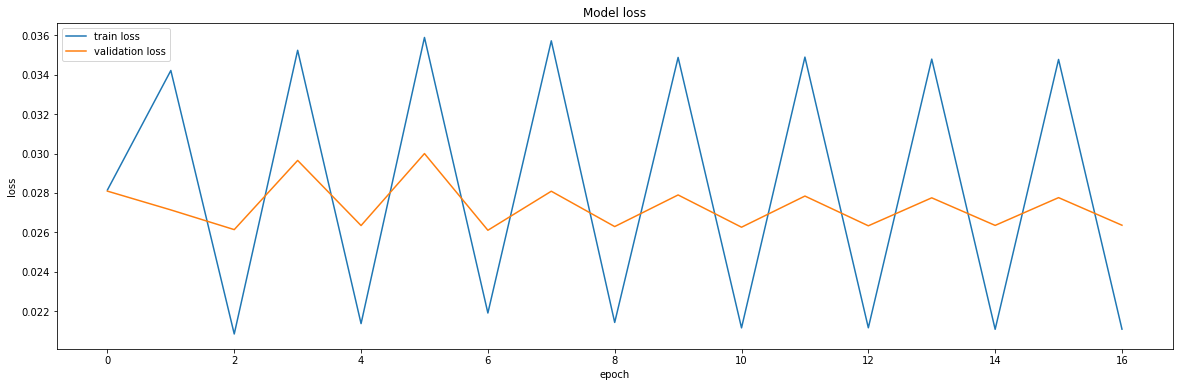

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [20,6]
plt.show()

In [131]:
data_val = x_scaler.fit_transform(account_data[['sales','spend','orders','clicks','impressions']].tail(1000))
print(data_val)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(data_val.shape)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
print(val_rescaled)
print(val_rescaled.shape)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
Predicted_results = Trained_model.predict(val_rescaled)[0]
print(Predicted_results)
print(len(Predicted_results))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(Predicted_results_Inv_trans)
print(len(Predicted_results_Inv_trans))

[[0.05574944 0.05446305 0.33333333 0.11764706 0.04618956]
 [0.06431877 0.06827946 0.07407407 0.08941176 0.19606339]
 [0.12428871 0.2133392  0.03703704 0.13411765 0.44295952]
 ...
 [0.33844811 0.33373984 0.14814815 0.19529412 0.72526496]
 [0.26283674 0.07090064 0.11111111 0.10588235 0.08462703]
 [0.74575727 0.69723588 0.2962963  0.78352941 0.25808015]]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
(1000, 5)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[[[0.05574944 0.05446305 0.33333333 0.11764706 0.04618956]
  [0.06431877 0.06827946 0.07407407 0.08941176 0.19606339]
  [0.12428871 0.2133392  0.03703704 0.13411765 0.44295952]
  ...
  [0.33844811 0.33373984 0.14814815 0.19529412 0.72526496]
  [0.26283674 0.07090064 0.11111111 0.10588235 0.08462703]
  [0.74575727 0.69723588 0.2962963  0.78352941 0.25808015]]]
(1, 1000, 5)
%%%

1/1 [==============================] - 4s 4s/step
[[0.03208499]
 [0.04870718]
 [0.06338814]
 [0.07620128]
 [0.08725202]
 [0.09667726]
 [0.10463531]
 [0.11129431]
 [0.11682203]
 [0.1213785 ]
 [0.12511122]
 [0.12815256]
 [0.13061886]
 [0.13261056]
 [0.13421322]
 [0.13549885]
 [0.13652746]
 [0.13734864]
 [0.13800302]
 [0.13852371]
 [0.1389376 ]
 [0.13926636]
 [0.1395273 ]
 [0.13973443]
 [0.13989882]
 [0.14002934]
 [0.14013302]
 [0.14021541]
 [0.14028095]
 [0.14033313]
 [0.14037472]
 [0.1404079 ]
 [0.14043443]
 [0.14045565]
 [0.14047264]
 [0.14048627]
 [0.14049724]
 [0.14050607]
 [0.14051318]
 [0.14051892]
 [0.1405236 ]
 [0.14052738]
 [0.14053044]
 [0.14053293]
 [0.14053497]
 [0.14053664]
 [0.140538  ]
 [0.14053912]
 [0.14054005]
 [0.14054082]
 [0.14054146]
 [0.14054199]
 [0.14054243]
 [0.14054279]
 [0.14054309]
 [0.14054336]
 [0.14054357]
 [0.14054374]
 [0.1405439 ]
 [0.14054403]
 [0.14054415]
 [0.14054425]
 [0.14054434]
 [0.1405444 ]
 [0.14054446]
 [0.1405445 ]
 [0.14054453]
 [0.14054458

In [132]:
testing = validate.copy()
testing[['pred_sales']] = Predicted_results_Inv_trans

In [133]:
testing['keywordId'].unique()

array(['178337812269813', '202640426426128', '190918643002238',
       '234598292844815', '115183597326876', '247863105542037',
       '272872700879778', '79454459707340', '85472206701258',
       '87296464240522', '234485565812381', '197034671889267',
       '67530812369819', '116716807274101', '227590663052584',
       '90306352578146', '148684437353570', '210247423029007',
       '13560133409311', '14934981931705', '64265992690180',
       '189229237302837', '185293015123540', '228625472493978',
       '86403799082238', '187760894834115', '67652894855323'],
      dtype=object)

In [134]:
testing[testing['keywordId'] == '85472206701258']

,sales,spend,clicks,impressions,orders,keywordId,pred_sales
date,,,,,,,
2022-12-13,9770.713900,1567.159497,96,31248,3,85472206701258,6118.978027
2022-12-14,11109.085380,1595.504897,97,31316,3,85472206701258,7155.073242
2022-12-15,9627.873996,1619.893577,97,31542,3,85472206701258,7158.194824
2022-12-16,9430.373463,1619.519767,96,31418,3,85472206701258,7158.234375
2022-12-17,10052.875668,1571.065132,93,31059,3,85472206701258,7158.234375
2022-12-18,9389.893579,1591.352447,94,30503,3,85472206701258,7158.234375
2022-12-19,9492.710435,1594.630788,95,30245,3,85472206701258,7158.234375
2022-12-20,8227.015711,1568.606683,95,30105,2,85472206701258,7158.234375
2022-12-21,7982.509616,1561.623125,95,30565,2,85472206701258,7158.234375


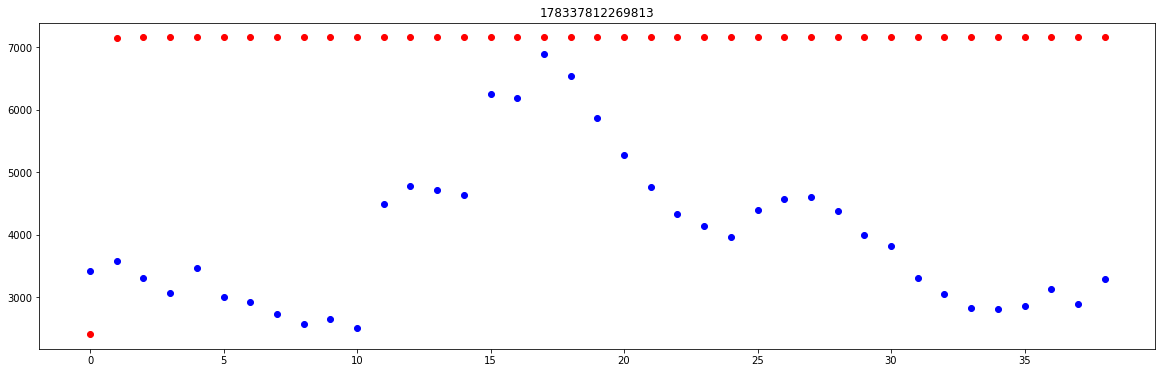

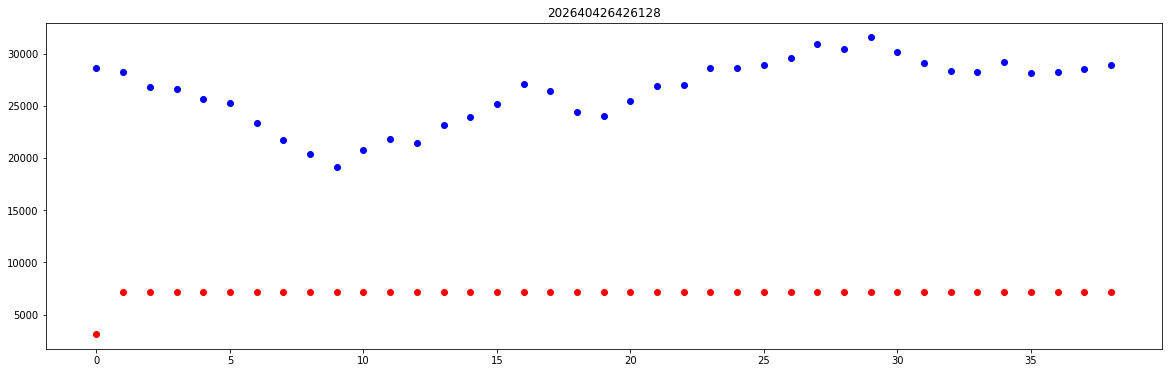

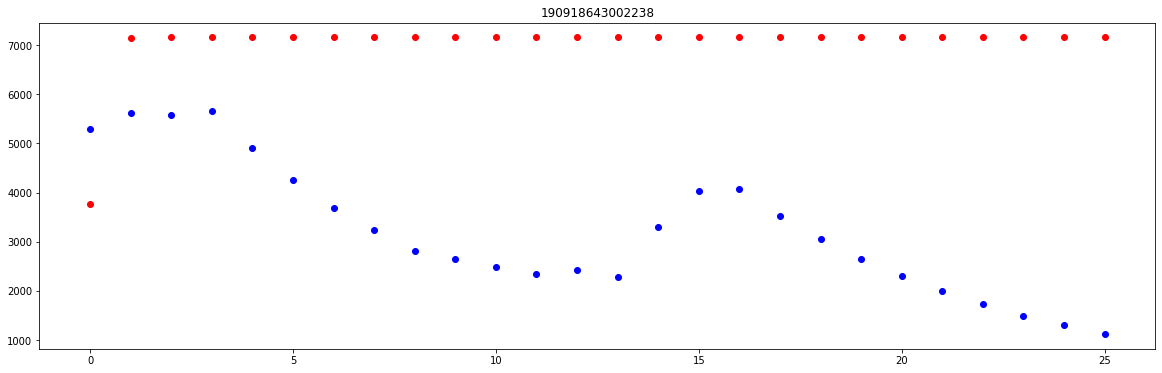

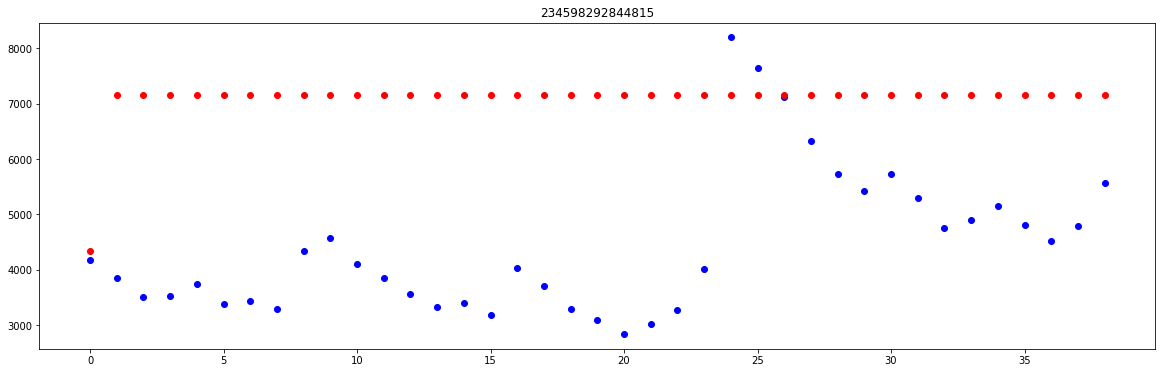

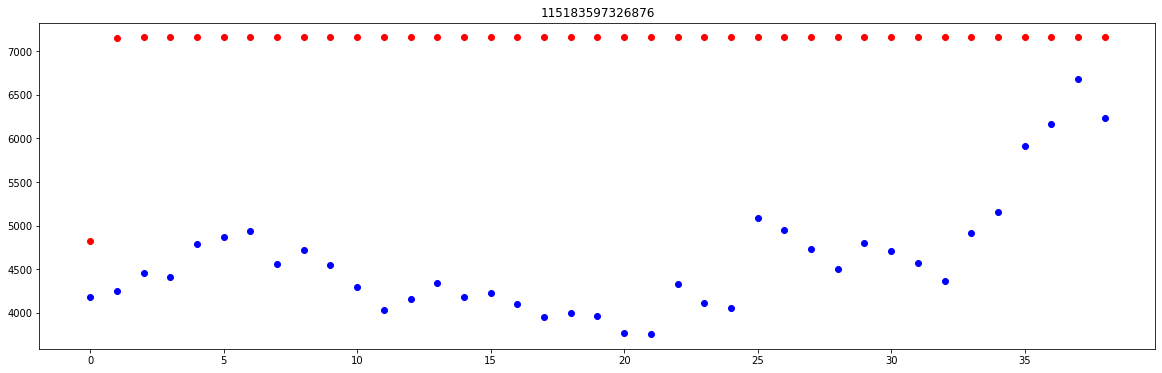

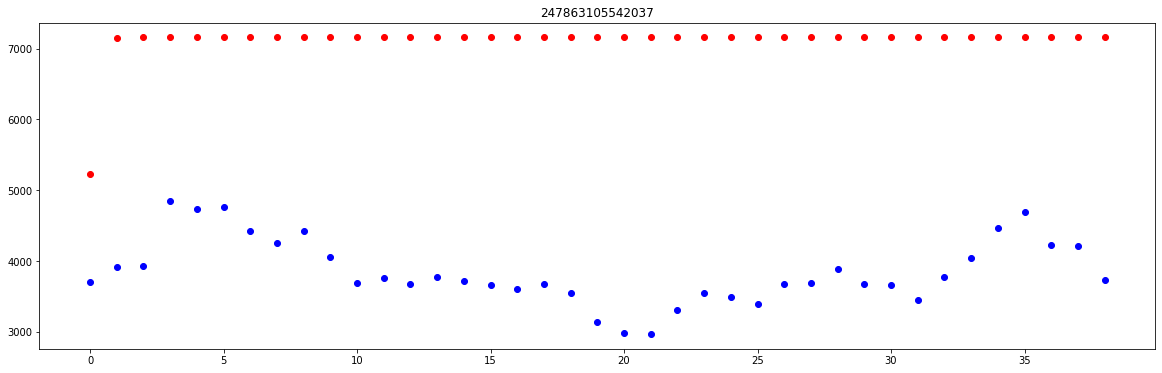

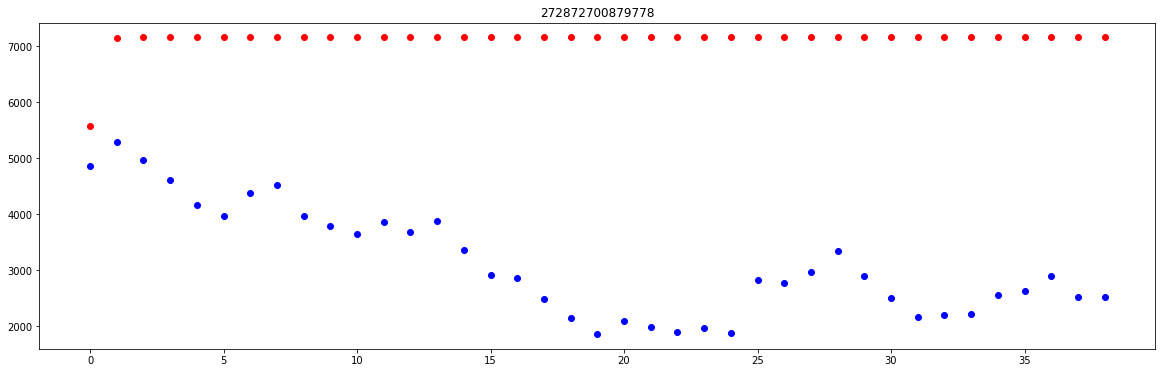

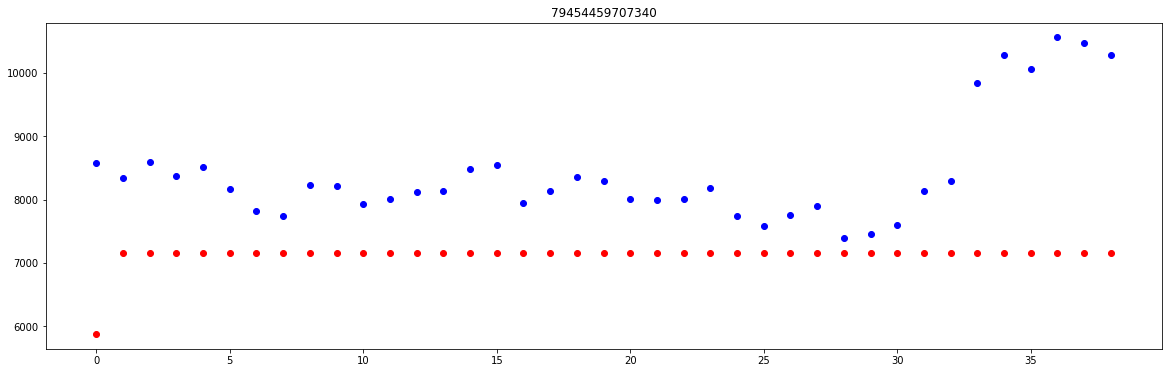

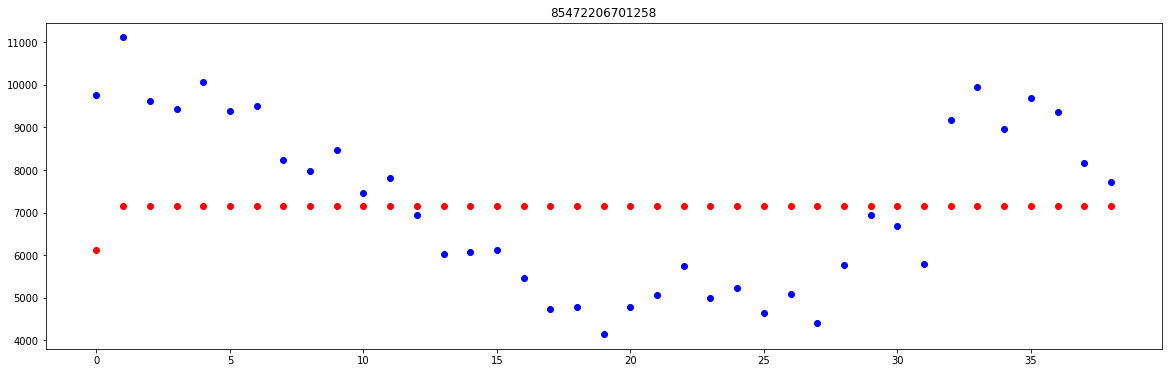

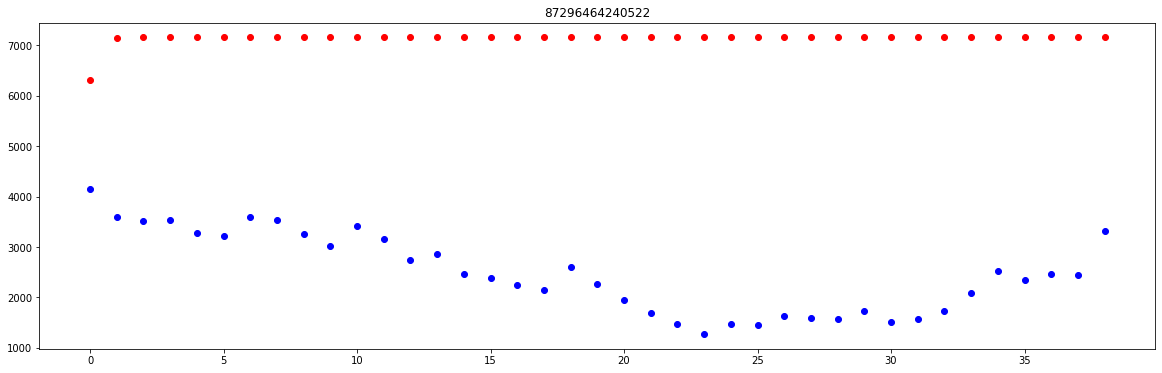

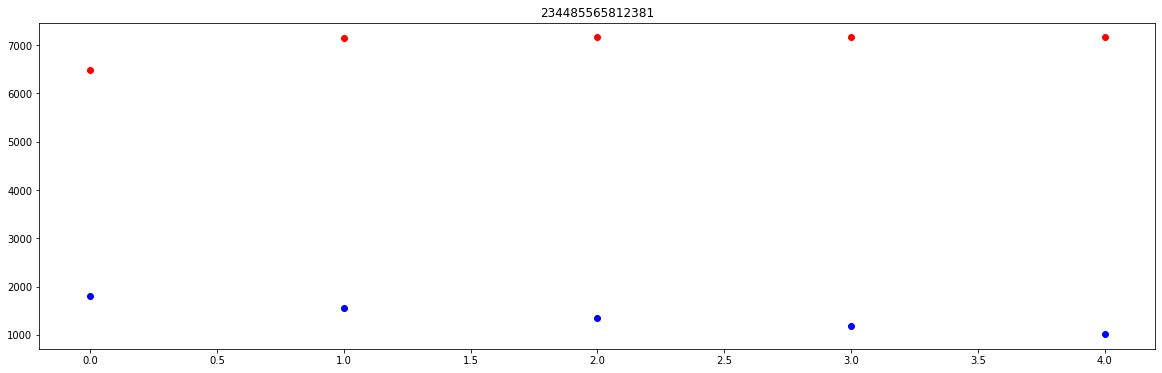

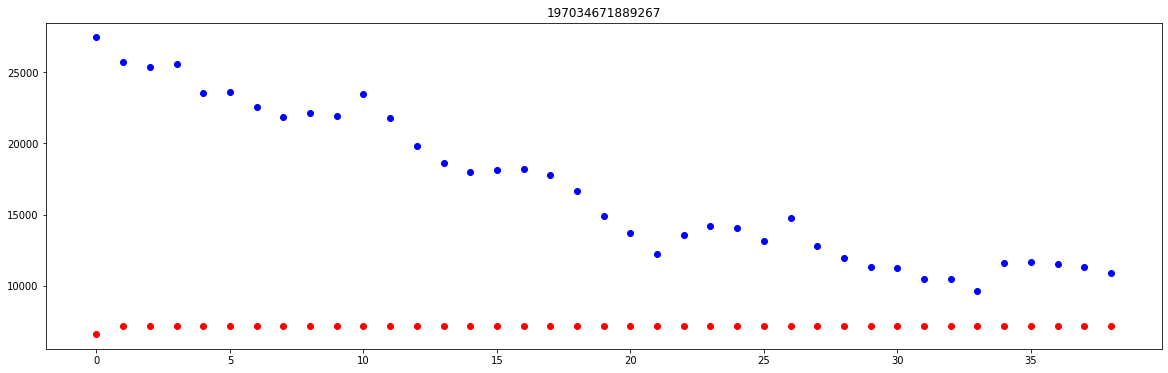

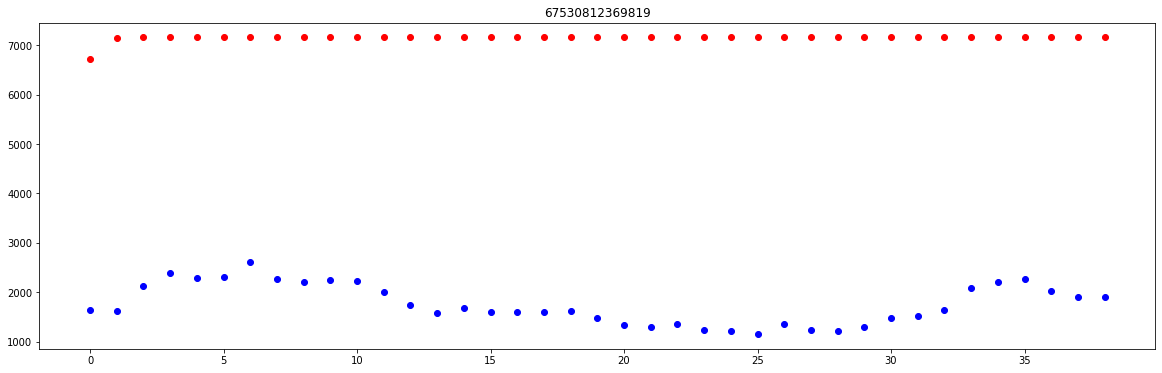

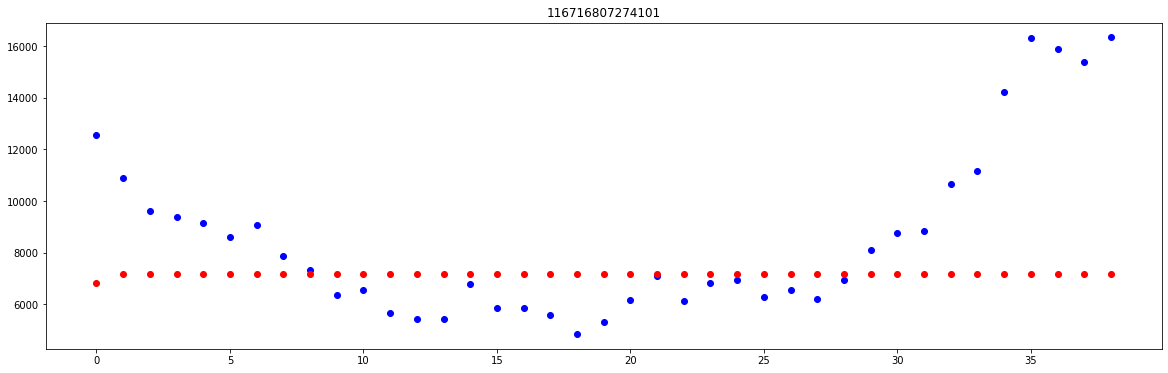

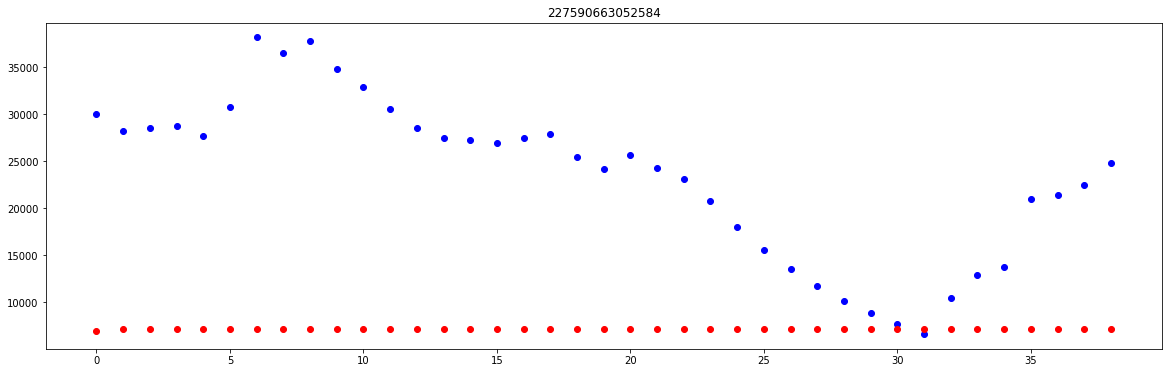

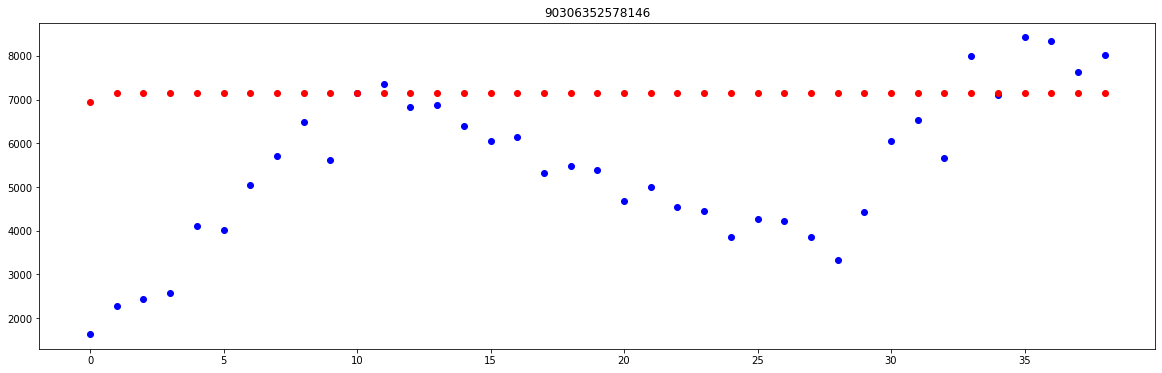

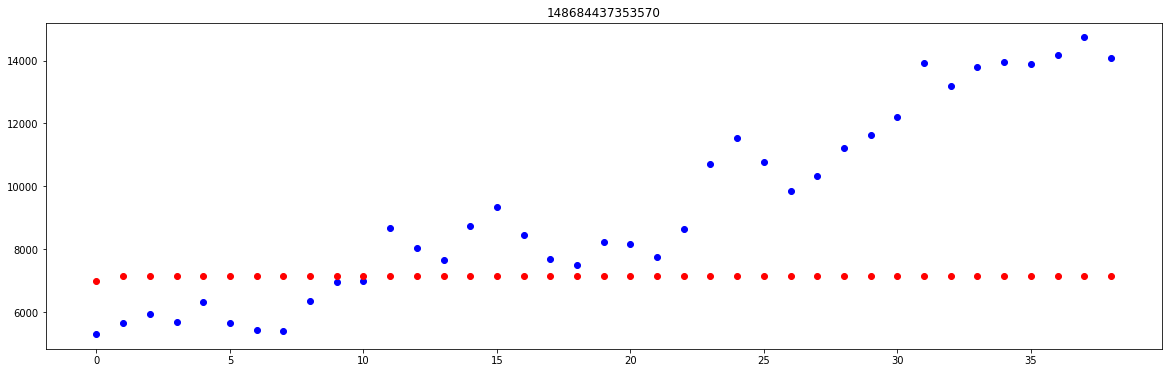

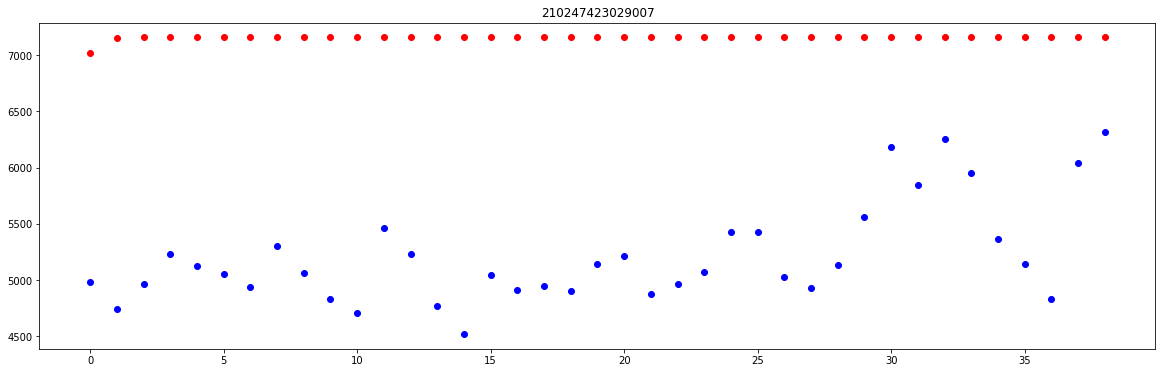

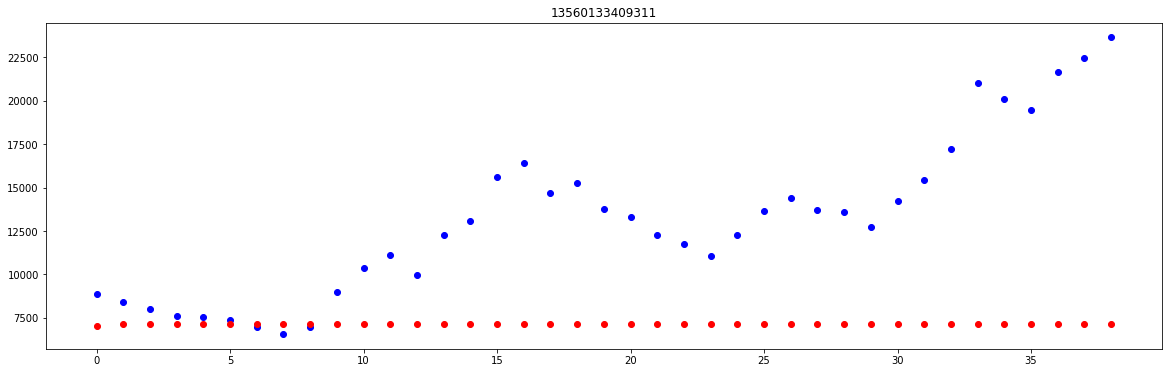

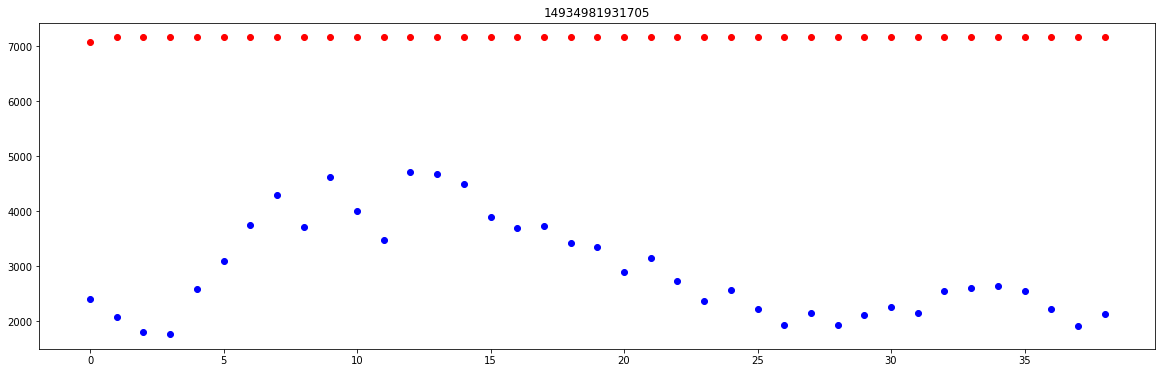

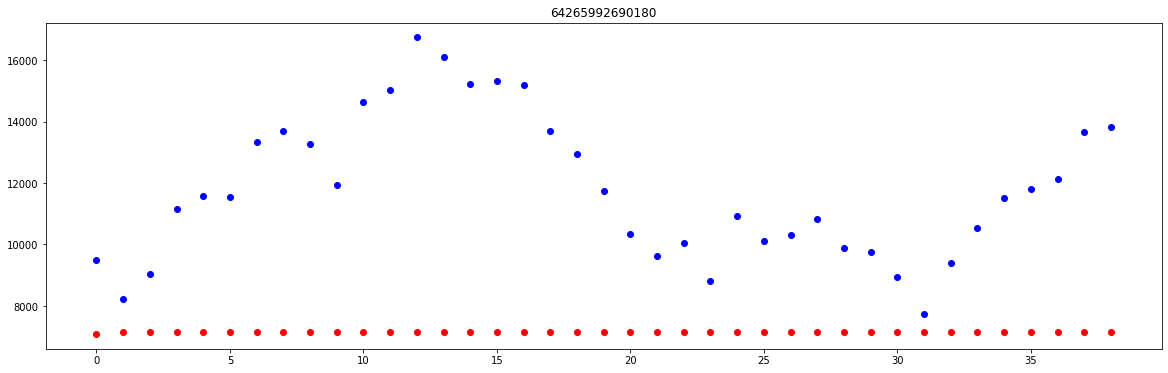

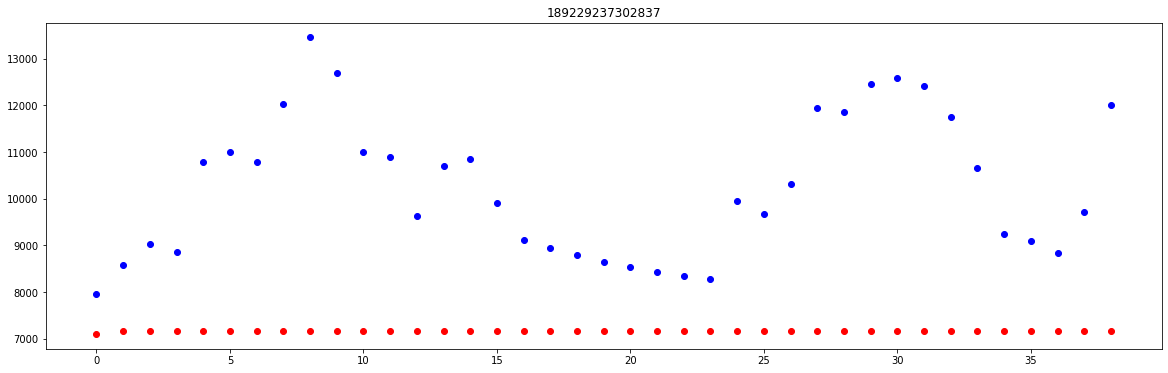

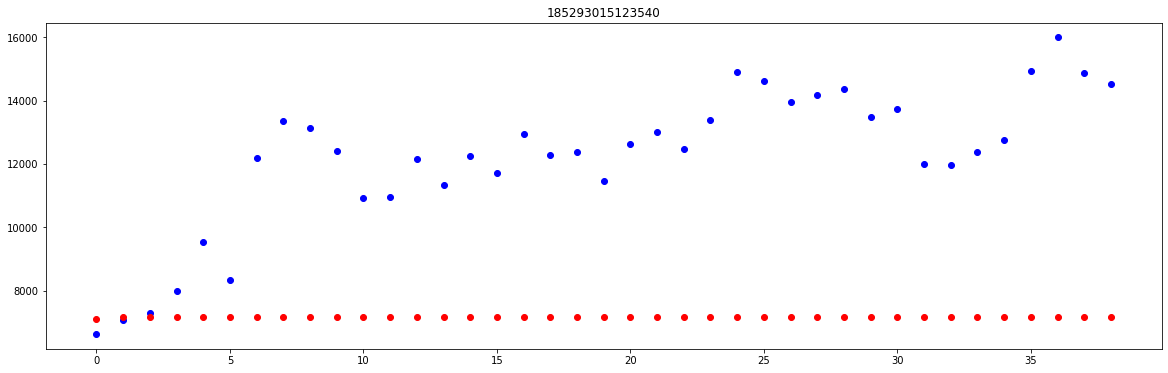

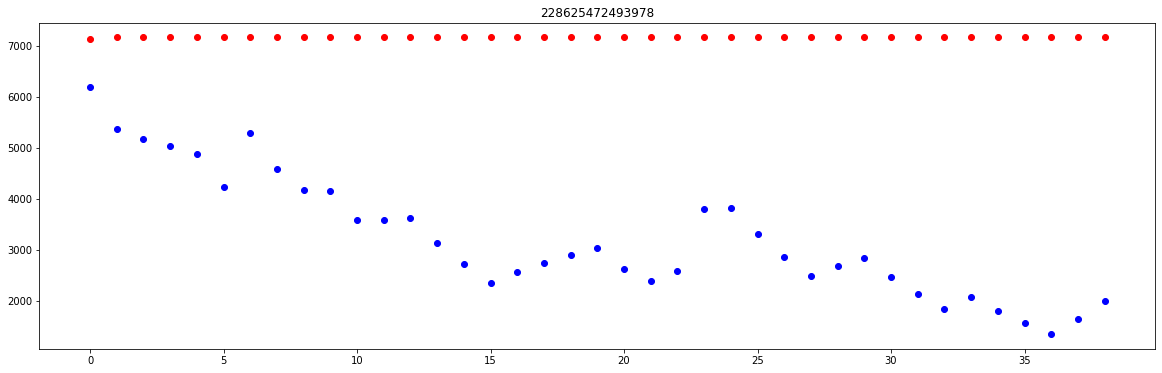

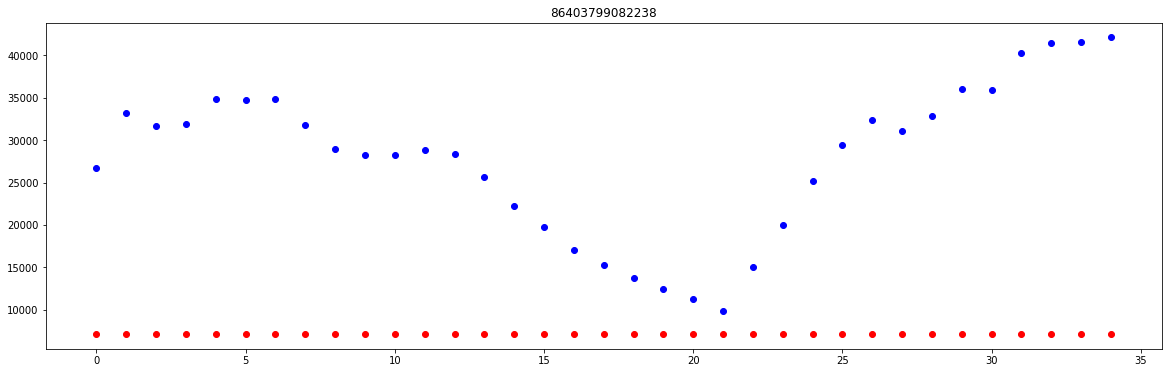

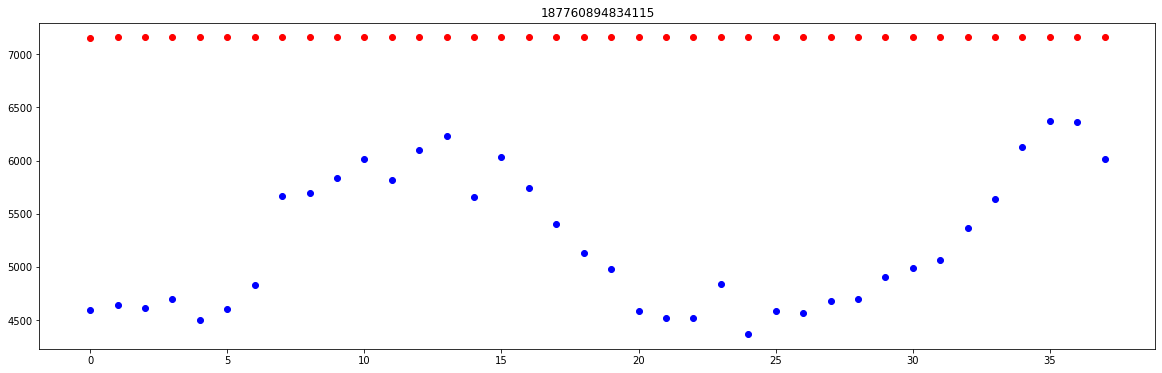

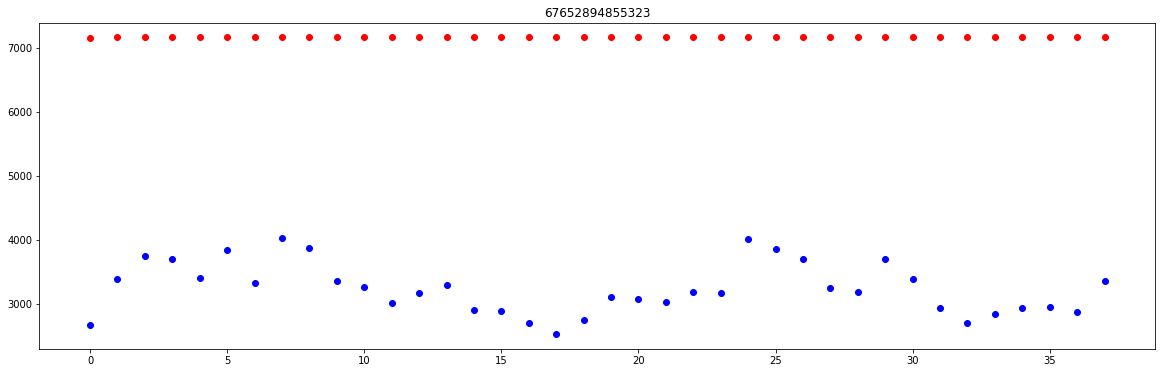

In [135]:
import matplotlib.pyplot as plt
import numpy as np
testing['keywordId'].unique()
for i in range(len(testing['keywordId'].unique())):
    def plotGraph(y_test,y_pred,s):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(s)
        plt.show()
        return
    s = testing['keywordId'].unique()[i]    
    y_sales = testing[testing['keywordId'] == s]['sales']
    y_pred_sales = testing[testing['keywordId'] == s]['pred_sales']
    plotGraph(y_sales, y_pred_sales,s)

In [ ]:
testing['keywordId'].unique()[9]

'234485565812381'